<a href="https://colab.research.google.com/github/wcl20/Imperial-460/blob/master/CW2/GenerativeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distribution of the input pixels. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 20
learning_rate  = 1e-3
batch_size = 128
### Choose a value for the size of the latent space
latent_dim = 32

###

# Define here the any extra hyperparameters you used.

# Weighting coefficient to balance reconstruction loss and KL divergence (Initial value)
beta = 0.2

###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor()
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

denorm = lambda x:x



## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Model Definition

In [0]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self, in_dim=784):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Encoder layers
        self.fc1 = nn.Linear(in_dim, 400)
        self.fc2 = nn.Linear(400, latent_dim) # mean
        self.fc3 = nn.Linear(400, latent_dim) # log variance
        # Decoder layers
        self.fc4 = nn.Linear(latent_dim, 400)
        self.fc5 = nn.Linear(400, in_dim)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = F.relu(self.fc1(x))
        # Return a vector of mu and logvar
        return self.fc2(x), self.fc3(x)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Calculate standard deviation from log variance
        sd = torch.exp(0.5 * logvar)
        # Sample z with mean and variance
        eps = torch.randn(latent_dim, device=sd.device)
        return mu + eps * sd

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(z))

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Encode
        mu, logvar = self.encode(x)
        # Sample
        z = self.reparametrize(mu, logvar)
        # Decode
        return self.decode(z), mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 667248
VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=32, bias=True)
  (fc3): Linear(in_features=400, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=784, bias=True)
)


## Training loop

In [0]:
# *CODE FOR PART 1.1b IN THIS CELL*
def loss_function_VAE(recon_x, x, mu, logvar, beta=1):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Compute reconstruction error using MSE
        recon_loss = F.mse_loss(recon_x, x, reduction="sum") 
        # Compute KL Divergence
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Compute loss with beta weighting
        total_loss = (recon_loss + beta * kl_loss) / x.shape[0]
        # Return losses
        return total_loss, recon_loss / x.shape[0], kl_loss / x.shape[0]

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

training_total_losses = []
training_recon_losses = []
training_kl_losses = []

testing_total_losses = []
testing_recon_losses = []
testing_kl_losses = []

betas = []

for epoch in range(num_epochs):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        model.train()
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        for batch_idx, data in enumerate(loader_train):
          # Send our batch to the device we are using.
          x, _ = data
          x = x.view(x.size(0), -1)
          x = x.to(device)
          # Zeroes the gradient used by optimizer
          optimizer.zero_grad()
          # Forward pass
          recon_x, mu, logvar = model(x)
          # Compute loss
          loss, recon_loss, kl_loss = loss_function_VAE(recon_x, x, mu, logvar, beta)
          epoch_total_loss += loss.item()
          epoch_recon_loss += recon_loss.item()
          epoch_kl_loss += kl_loss.item()
          # Back propagation
          loss.backward()
          optimizer.step()
        # Save losses after each epoch
        training_total_losses.append(epoch_total_loss / len(loader_train.dataset))
        training_recon_losses.append(epoch_recon_loss / len(loader_train.dataset))
        training_kl_losses.append(epoch_kl_loss / len(loader_train.dataset))
        # KL annealing
        betas.append(beta)
        beta += 0.1
        beta = min(beta, 0.8)
        # Test model 
        model.eval()
        test_total_loss = 0
        test_recon_loss = 0
        test_kl_loss = 0
        with torch.no_grad(): 
          for batch_idx, (x, _) in enumerate(loader_test):
              x = x.view(x.size(0), -1)
              x = x.to(device)
              recon_x, mu, logvar = model(x)
              # Compute loss
              loss, recon_loss, kl_loss = loss_function_VAE(recon_x, x, mu, logvar)
              test_total_loss += loss.item()
              test_recon_loss += recon_loss.item()
              test_kl_loss += kl_loss.item()
        # Save losses after each epoch
        testing_total_losses.append(test_total_loss / len(loader_test.dataset))
        testing_recon_losses.append(test_recon_loss / len(loader_test.dataset))
        testing_kl_losses.append(test_kl_loss / len(loader_test.dataset))
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

### Your explanations about the loss function here:
The loss function of VAE is composed of a reconstruction loss and a KL divergent loss. The reconstruction loss aims to optimize the performance of the encoding-decoding scheme. The KL divergent loss is used to make the latent space distribution close to a standard normal distribution.

The two most common reconstruction loss functions are Mean Squared Error (MSE) and Binary Cross Entropy (BCE). MSE is used if the probabilistic decoder predicts the mean and variance of a Gaussian. BCE is used if the probabilistic decoder predicts the probability of a sample being equal to 1. Here, MNIST images are not binary encoded (shown below), but has values range in between 0 and 1. Assuming pixel values are normally distributed, it is more suitable to use MSE as reconstruction loss.

Different betas affects the weighting of the two loss terms. A low beta puts more focus on minimizing reconstruction error. This can create a VAE that can encode and decode with almost no information loss, however the latent space representation becomes meaningless. A high beta focuses on making the latent space close to a normal distriubution, however the reconstructed image becomes very noisy. After experimenting with different beta values, it is found that 0.8 (final value) gives the most desirable results.

In [0]:
# Get number of different value pixel in the image
img, label = test_dat.__getitem__(0)
print("The first image contains {} different value pixels".format(len(np.unique(img.numpy()))))
print("Min value: {}".format(np.min(img.numpy())))
print("Max value: {}".format(np.max(img.numpy())))

The first image contains 72 different value pixels
Min value: 0.0
Max value: 1.0


## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


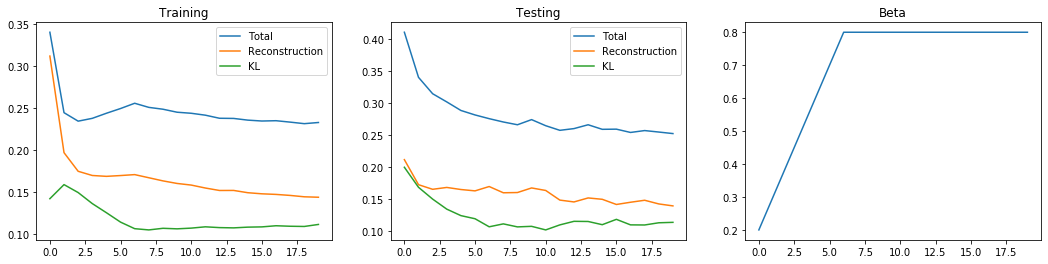

In [0]:
# *CODE FOR PART 1.2a IN THIS CELL*
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(18)

axs[0].set_title("Training")
axs[0].plot(list(range(0, np.array(training_total_losses).shape[0])), training_total_losses, label="Total")
axs[0].plot(list(range(0, np.array(training_recon_losses).shape[0])), training_recon_losses, label="Reconstruction")
axs[0].plot(list(range(0, np.array(training_kl_losses).shape[0])), training_kl_losses, label="KL")
axs[0].legend(loc="upper right")


axs[1].set_title("Testing")
axs[1].plot(list(range(0, np.array(testing_total_losses).shape[0])), testing_total_losses, label="Total")
axs[1].plot(list(range(0, np.array(testing_recon_losses).shape[0])), testing_recon_losses, label="Reconstruction")
axs[1].plot(list(range(0, np.array(testing_kl_losses).shape[0])), testing_kl_losses, label="KL")
axs[1].legend(loc="upper right")

axs[2].set_title("Beta")
axs[2].plot(list(range(0, np.array(betas).shape[0])), betas)

### Your answer to 1.2b here:
When using a constant value for beta (beta=0.8), posertior collapse was observed during training. The value for KL loss is very small during the early stages of training and this leads to model degeneration. Posterior collapse causes two undesirable outcomes: 1) The decoder completely ignores the latent features and produces genertic outputs that are crude representatives of all seen inputs. 2) The learned features becomes identical to the uninformative Gaussian prior and is disconnected from the input. When using a constant beta, the randomly generated digits cannot be distinguished and looks like generic representation of all the digits.

KL annealing was used to mitigate the problem with posterior collapse. It starts with a small beta=0.2 at the beginning of the training and gradually increase beta until it reaches 0.8. At the early stages, the neural network focus more on capturing useful information for reconstructing the input. Once it learns how to reconstruct the input, it considers the full VAE objective to regularise the latent space.

From the graphs, the total loss and reconstruction loss is constantly reducing. A lower reconstruction loss indicates better performance of the encoder-decoder scheme. KL loss starts with a high value, due to KL annealing,then decreases to smaller value. A smaller KL loss indicates the latent distribution is closer to standard normal distribution. The generated digits looks much better using KL annealing and becomes recognizable.

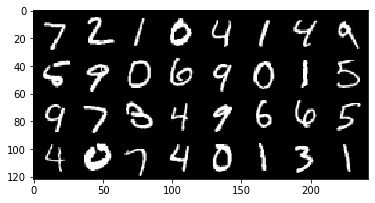

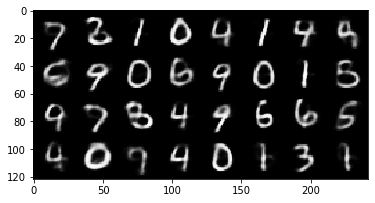

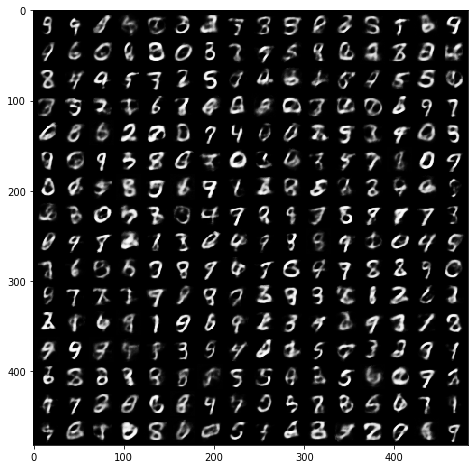

In [0]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    fixed_input = fixed_input.view(fixed_input.size(0), -1)
    fixed_input = fixed_input.to(device)
    recon_batch, _, _ = model(fixed_input)
    recon_batch = recon_batch.view(-1, 1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    samples = samples.view(-1, 1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

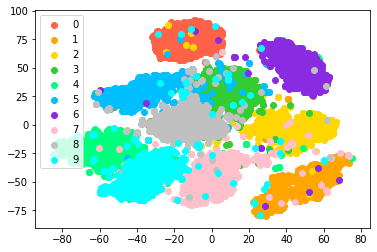

In [0]:
# *CODE FOR PART 1.3a IN THIS CELL*
from sklearn.manifold import TSNE 

# Encode test set images
loader_test = DataLoader(test_dat, 10000, shuffle=False)
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
with torch.no_grad(): 
  for batch_idx, (x, y) in enumerate(loader_test):
    x = x.view(x.size(0), -1)
    x = x.to(device)
    mu, logvar = model.encode(x)
    z = model.reparametrize(mu, logvar)

# Perform TSNE
tsne = TSNE()
z = z.cpu().numpy()
z_embedded = tsne.fit_transform(z)

# Plot Scatter graph
y = y.numpy()
colors = 'tomato', 'orange', 'gold', 'limegreen', 'springgreen', 'deepskyblue', 'blueviolet', 'pink', 'silver', 'cyan'
for number, color in zip(list(range(10)), colors):
  plt.scatter(z_embedded[y==number,0], z_embedded[y==number,1], c=color, label=str(number))
plt.legend()
plt.show()


### Your answer to 1.3a here:
The numbers are organized according to their location in the latent space, each digit is represented by a different color. 

All the points are close together in the latent space. This is because the KL divergence term in the loss function forced the latent distribution to be close to the standard normal distribution. 

The latent space is segmented into distinctive clusters that represent different digit class. Furthermore, similar digits are placed closer together in the latent space. For instance, '3's are close to '5's and '8's, '4's are close to '9's.



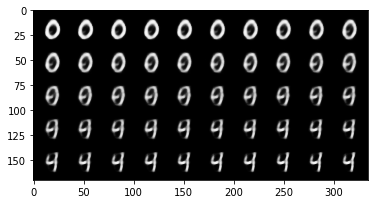

In [0]:
# *CODE FOR PART 1.3b IN THIS CELL*
# Latent representation of the number 0
z_1 = z[y == 0][0]
# Latent representation of the number 4
z_2 = z[y == 4][2]
# Interpolate latent space
samples = [z_1 + (z_2 - z_1) * n / 49 for n in range(50)]
# Decode and show image
samples = torch.Tensor(samples).to(device)
with torch.no_grad():
  samples = model.decode(samples)
  samples = samples.view(-1, 1, 28, 28)
  samples = samples.cpu()
  samples = make_grid(denorm(samples), nrow=10, padding=5, normalize=False,
                          range=None, scale_each=False, pad_value=0)
  show(samples)


### Your answer to 1.3b here:
The image shows the transition from digit '0' to digit '4'.

There is a continuum between different digit class. From the image, the '0' prgressively turn into '9' and then turn into '4'. This agrees with the latent space representation, in which '9's are in between '0's and '4's.

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [0]:
batch_size = 128  # change that
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 20
learning_rate  = 1e-4
latent_vector_size = 100
###

# Define here other hyperparameters that you used.

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self, in_dim=latent_vector_size):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.hidden0 = nn.Sequential(
            # Output shape: 512 x 4 x 4
            nn.ConvTranspose2d(latent_vector_size, out_channels=512, kernel_size=4),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        self.hidden1 = nn.Sequential(
            # Output shape: 256 x 8 x 8
            nn.ConvTranspose2d(512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        self.hidden2 = nn.Sequential(
            # Output shape: 128 x 16 x 16
            nn.ConvTranspose2d(256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        self.hidden3 = nn.Sequential(
            # Output shape: 3 x 32 x 32
            nn.ConvTranspose2d(128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.hidden0(z)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.hidden0 = nn.Sequential(
            # Output shape: 128 x 16 x 16
            nn.Conv2d(3, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True)
        )

        self.hidden1 = nn.Sequential(
            # Output shape: 256 x 8 x 8
            nn.Conv2d(128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True)
        )

        self.hidden2 = nn.Sequential(
            # Output shape: 512 x 4 x 4
            nn.Conv2d(256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True)
        )

        self.hidden3 = nn.Sequential(
            # Output shape: 1 x 1 x 1
            nn.Conv2d(512, out_channels=1, kernel_size=4),
            nn.Sigmoid()
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.hidden0(x)
        out = self.hidden1(out)
        out = self.hidden2(out)
        out = self.hidden3(out)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3449475
Generator(
  (hidden0): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden3): Sequential(
    (0): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)


Total number of parameters in Discriminator is: 2638465
Discriminator(
  (hidden0): Sequential(
    (0): Conv2d(3, 128, k

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

Streaming output truncated to the last 5000 lines.
[6/20][363/383] Loss_D: 0.3448 Loss_G: 2.6260 D(x): 0.8101 D(G(z)): 0.0854 / 0.1082
[6/20][364/383] Loss_D: 0.4032 Loss_G: 3.0853 D(x): 0.8779 D(G(z)): 0.2124 / 0.0647
[6/20][365/383] Loss_D: 0.3217 Loss_G: 3.5786 D(x): 0.8769 D(G(z)): 0.1468 / 0.0429
[6/20][366/383] Loss_D: 0.3933 Loss_G: 2.7614 D(x): 0.7996 D(G(z)): 0.1179 / 0.0864
[6/20][367/383] Loss_D: 0.3482 Loss_G: 2.8602 D(x): 0.8513 D(G(z)): 0.1464 / 0.0876
[6/20][368/383] Loss_D: 0.2510 Loss_G: 3.4720 D(x): 0.9064 D(G(z)): 0.1271 / 0.0496
[6/20][369/383] Loss_D: 0.3154 Loss_G: 3.4927 D(x): 0.8813 D(G(z)): 0.1508 / 0.0440
[6/20][370/383] Loss_D: 0.2558 Loss_G: 2.9078 D(x): 0.8418 D(G(z)): 0.0530 / 0.0761
[6/20][371/383] Loss_D: 0.4230 Loss_G: 4.0029 D(x): 0.9054 D(G(z)): 0.2507 / 0.0263
[6/20][372/383] Loss_D: 0.3525 Loss_G: 2.6906 D(x): 0.7841 D(G(z)): 0.0755 / 0.0945
[6/20][373/383] Loss_D: 0.4154 Loss_G: 2.2065 D(x): 0.8091 D(G(z)): 0.1551 / 0.1475
[6/20][374/383] Loss_D: 0

### DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL

A generative adversarial network (GAN) has two parts: a generator that learns how to generate plausible data and a discriminator that learns how to classify fake data from real data. The above architecture follows the one described in the DCGAN paper. I experimented with different implementations to try understand why the architecture proposed has the best performance.

The first interesting feature I noticed in the GAN architecture is that it uses stride in convolutional layers to perform downsampling instead of the typical maxpooling layers. I tried to use maxpooling and meanpooling to down sample images and was able to achieve similar results with the cifar10 dataset.

Batch Normalization plays a significant role in GAN architecture. It standardize the layer to have zero mean and unit variance, which stablizes the training process. Without the BatchNorm layers, the generated images are all black. When building the Generator, I accidentally added a BatchNorm layer to the generator output (Before tanh) and found out having a BatchNorm in the output layer produces worse results.

Relu is used to prevent the vanishing gradient problem. In the proposed architecture, the generator uses Relu activation in all layers and the discriminator uses leaky Relu activation for all layers. I experimented with different values for leaky relu but it does not seem to make a significant difference.

GAN uses Adam optimizer. I tried to use SGD optimizer and experimented with different beta values and found out using Adam gives the best performance.

### Generator samples

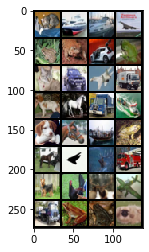

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

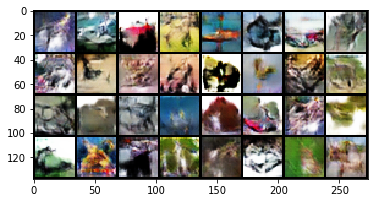

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

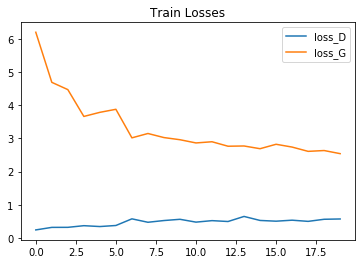

In [0]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

### ANSWER FOR PART 2.2 IN THIS CELL

The underlying principle of GAN is to train a generator and disriminator that are constantly competing. This makes GAN very difficult to train because improving one model comes at the expense of the other model. 

From the loss curves, the Generator loss decreases gradually. On the other hand, the Disriminator loss steadily increases to a constant value. 

At the beginning of training, the Generator wasn't able to produce plausible fake data and the discriminator can easily distinguish fake data from real data. This explains why the Generator loss is high at the beginning while the Discriminator loss is much lower. Throughout the training, the Generator becomes better at producing fake images and so generator loss starts to decrease. On the contrary, it becomes more difficult for the discriminator to differentiate fake and real data and so discriminator loss increases. At the end, the generator becomes so good at producing fake data that the discriminator can no longer tell the difference between real and fake data and so discriminator loss reaches an equilibrium point and remains constant. 

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

### ANSWER FOR PART 2.3 IN THIS CELL

Mode collapse is a challenging model failure for GAN. This occurs when the generator learns to produce only one plausible output to deceive the discriminator. Ideally, we would like the generator to be able to generate a diverse set of fake data. With mode collapse, the generator learns to map several different input z values to the same output, as a result all the images generated will look almost identical. 

From the results, the GAN was able to generate a diversity of output data. This means the model did not experience any mode collapse.

Even if the GAN was to experience mode collapse, there are different approaches to tackle the problem. One approach is to make the disrciminator reject the outputs that the generator stabilizes on. This way the generator will not be able to deceive the discriminator